<h1>A. Data Collection & Exploration

<h2>Import libraries

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval
from sklearn.cluster import KMeans
from statistics import mean
import sklearn.metrics

<h2>Import dataset

In [2]:
df_data = pd.read_csv('HR_comma_sep.csv')
df_data.index.name = "id"
df_model = df_data.copy()

<h2>Data exploratioin

In [3]:
pd.options.display.max_columns=100
df_model.head()
# df_model.Stay

# for x in df_model.Stay:
#     if df_model.Stay[x] != 0:
#       print(df_model.Stay[x])
#     else:
#       message ="no employee stay find!";
#       print(message)
#       break;

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<h2>Define Cols

In [4]:
#choose the single dependent variable (Positive Outcome)
treat = 'promotion_last_5years'

In [5]:
#choose the treatment variable
target = "left"

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


<h2>Check N-uniques for non-categorical data

In [7]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype != "object"]
numbers = [[obj,df_data[obj].nunique()] for obj in object_cols]
numbers_data = pd.DataFrame(numbers, columns = ['column', 'N-unique']) 

In [8]:
numbers_data.sort_values(by='N-unique',ascending=False)

,column,N-unique
3,average_montly_hours,215
0,satisfaction_level,92
1,last_evaluation,65
4,time_spend_company,8
2,number_project,6
5,Work_accident,2
6,left,2
7,promotion_last_5years,2


<h2>Define Columns to Cluster</h2>
Define column to cluster with high amount of N-Uniques

In [9]:
#choose a column with hiearchy to be label encoded
cluster_cols=['average_montly_hours']

<h2>Check uniques for categorical data

In [10]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_data[obj].unique():
        print("{} {}".format(unique,sum(df_data[obj] == unique)))


 Department
sales 4140
accounting 767
hr 739
technical 2720
support 2229
management 630
IT 1227
product_mng 902
marketing 858
RandD 787

 salary
low 7316
medium 6446
high 1237


<h2>Replace Yes or No to 1 or 0

In [11]:
# df_model.Attrition.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)
# df_model.OverTime.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)

<h2>Rename Data

In [12]:
df_model[[treat,target]].head()

,promotion_last_5years,left
id,,
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


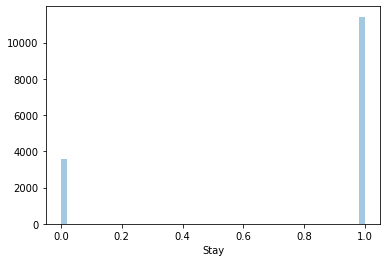

In [13]:
df_model = df_model.rename(columns={"left": "Stay"})
df_model.Stay = df_model.Stay.replace({0:1, 1:0})
sns.distplot(a=df_model.Stay, hist=True,kde=False)
# df_model = df_model.rename(columns={"promotion_last_5years": "NotOvertime"})
# treat = 'NotOvertime'


In [14]:
df_model.Stay

id
0        0
1        0
2        0
3        0
4        0
        ..
14994    0
14995    0
14996    0
14997    0
14998    0
Name: Stay, Length: 14999, dtype: int64

<h2>Invert Target Value(Churn to Stay)

In [15]:
# sns.distplot(a=df_model.Stay, hist=True,kde=False)

B.6. Inverting data from column 'Stay':[0 0 0 0 0 0 0 0 0 0] ... 
Inverted result named 'stay':[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ... 
Column 'left' has been successfully replaced by new column 'stay'!


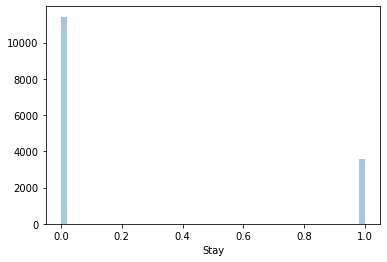

In [16]:
#setup the target column to be inverted and prepare empty array named inverted
input_data = df_model.Stay
inverted = []
print ("B.6. Inverting data from column '{}':{} ... ".format(input_data.name,df_model.Stay.values[:10]))

#inverting through all datas in column
for i in range(len(input_data)):
    inverted.append(1 - input_data[i])
print ("Inverted result named 'stay':{} ... ".format(inverted[:10]) )

#add new column stay and remove column left
df_model['Stay']=inverted
print ("Column 'left' has been successfully replaced by new column 'stay'!")

#check the result
sns.distplot(a=df_model.Stay, hist=True,kde=False)

<h2>Define columns to Label encode

In [17]:
# df_model[object_cols].head()
df_model.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Stay,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [18]:
#choose a column with wide range to be clusterred
label_cols = ['salary']

<h1>B. Data Preprocessing

<h2>Label encoding hierarchy columns

In [19]:
#Label encoding
print("label encoding columns:",label_cols)
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])
print(">>label encoding finished")
df_model[label_cols].head()

label encoding columns: ['salary']
>>label encoding finished


,salary
id,
0,1
1,2
2,2
3,1
4,1


<h2>Data cleaning

In [20]:
df_model.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Stay,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,1
1,0.80,0.86,5,262,6,0,1,0,sales,2
2,0.11,0.88,7,272,4,0,1,0,sales,2
3,0.72,0.87,5,223,5,0,1,0,sales,1
4,0.37,0.52,2,159,3,0,1,0,sales,1


In [21]:
#DROP unused columns
# df_model = df_model.drop(['Over18','StandardHours','StockOptionLevel','EmployeeCount','EmployeeNumber'],axis=1)

<h2>Cluster & One Hot Encoding

In [22]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [23]:
#preparing float columns to cluster
print('Clustering columns:',cluster_cols)
#creating the clusters
for col in cluster_cols:
    col_cluster = col + "_cluster"
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(df_model[[col]])
    df_model[col_cluster] = kmeans.predict(df_model[[col]])
    #order the clusters
    df_model = order_cluster(col_cluster, col, df_model, True)
print('>>Cluster succeeded!')
#dropping columns that have been clustered
df_model = df_model.drop(cluster_cols,axis=1)

#one hot encoding the rest columns
dummies = pd.get_dummies(df_model)
print("\nOne Hot Encoding:",dummies.columns.values)
df_model = dummies
print('>>One Hot Encoding succeeded!')

Clustering columns: ['average_montly_hours']
>>Cluster succeeded!

One Hot Encoding: ['satisfaction_level' 'last_evaluation' 'number_project'
 'time_spend_company' 'Work_accident' 'Stay' 'promotion_last_5years'
 'salary' 'average_montly_hours_cluster' 'Department_IT'
 'Department_RandD' 'Department_accounting' 'Department_hr'
 'Department_management' 'Department_marketing' 'Department_product_mng'
 'Department_sales' 'Department_support' 'Department_technical']
>>One Hot Encoding succeeded!


In [24]:
df_model

,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,Stay,promotion_last_5years,salary,average_montly_hours_cluster,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
0,0.38,0.53,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
1,0.37,0.52,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
2,0.41,0.50,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
3,0.41,0.55,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
4,0.45,0.47,2,3,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.25,0.46,4,4,0,1,0,2,2,0,0,0,0,0,0,0,0,0,1
14995,0.48,0.78,2,2,0,1,0,2,2,0,0,0,0,0,0,0,0,0,1
14996,0.80,0.83,2,3,0,1,0,1,2,0,0,0,0,0,0,0,0,1,0
14997,0.73,0.97,6,2,0,1,0,1,2,0,0,0,0,0,0,0,1,0,0


<h2>Categorizing target class

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull!


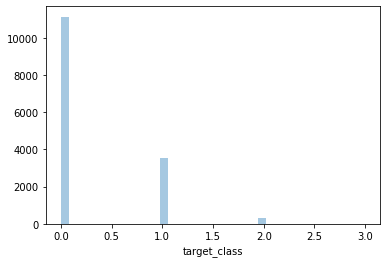

In [25]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model[treat] == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model[treat] == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model[treat] == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR

print(">>Categorizing successfull!")
sns.distplot(a=df_model.target_class, kde=False)

<h2>Explore data Correlation

In [26]:
#measure the correlation of Employee who stay
pd.options.display.max_rows=100
correlation = df_model.corr(method ='pearson') 
correlation = correlation.Stay.sort_values() * 100

In [27]:
pd.DataFrame(correlation)

,Stay
satisfaction_level,-38.837498
Work_accident,-15.462163
promotion_last_5years,-6.178811
Department_RandD,-4.659565
Department_management,-4.603539
Department_product_mng,-1.102915
Department_IT,-1.092483
salary,-0.129372
Department_marketing,-0.085930
last_evaluation,0.656712


<h2>Invert negative correlation(if available)

<h2>Create new dataframe for churn and uplift

In [28]:
#duplicate result to df_data for calculating MP & MPU
df_data_churn = df_model[['target_class','Stay',treat]]
# df_data_lift = df_model.copy()
df_data_uplift = df_model[['target_class','Stay',treat]]
print(df_data_uplift.head())

   target_class  Stay  promotion_last_5years
0             1     1                      0
1             1     1                      0
2             1     1                      0
3             1     1                      0
4             1     1                      0


<h2>Predicting Target Class(Churn Uplift)

In [29]:
#create feature set and labels
X = df_model.drop(['target_class',treat,'Stay'],axis=1)
y = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict = xgb_model.predict(df_model.drop(['target_class',treat,'Stay'],axis=1))
overall_proba=xgb_model.predict_proba(df_model.drop(['target_class',treat,'Stay'],axis=1))
# insert predicted target to uplift dataframe
df_data_uplift['p_target'] = overall_predict
df_model['p_target'] = overall_predict
# assign probabilities to 4 different columns
df_data_uplift['proba_CN'] = overall_proba[:,0] 
df_data_uplift['proba_CR'] = overall_proba[:,1] 
df_data_uplift['proba_TN'] = overall_proba[:,2] 
df_data_uplift['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_data_uplift['uplift_score'] = df_data_uplift.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')
#assign it back to main dataframe
df_data_uplift['uplift_score'] = df_data_uplift['uplift_score']

C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

<h2>Predicting Target (Churn Prediction)

In [30]:
#create feature set and labels
z = df_model.Stay
#splitting train and test groups
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model2 = xgb.XGBClassifier().fit(X_train, z_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict2 = xgb_model2.predict(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
overall_proba2 = xgb_model2.predict_proba(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
# df_data_lift = df_model.copy()
df_data_churn['p_stay'] = overall_predict2
df_model['p_stay'] = overall_predict2
df_data_churn['stay_score'] = overall_proba[:,1] 
df_data_churn['churn_score'] = overall_proba[:,0] 

C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\HabbeybDS\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

<h2>Rank data from Churn prediction

In [31]:
#both treatment and control
print("Ranking data for Churn Prediction with control included")
df_data_churn_all = df_data_churn.copy()
df_data_churn_all = df_data_churn_all.sort_values(by ='stay_score',ascending=False)
df_data_churn_all = df_data_churn_all.reset_index()

#treatment only
df_data_churn = df_data_churn[df_data_uplift.target_class > 1]
print("Ranking data for Churn Prediction with control not included")
df_data_churn = df_data_churn.sort_values(by ='stay_score',ascending=False)
df_data_churn = df_data_churn.reset_index()

Ranking data for Churn Prediction with control included
Ranking data for Churn Prediction with control not included


<h2>Rank data from Uplift prediction

In [32]:
#both treatment and control
print("Ranking data for Churn Uplift with control included")
df_data_uplift_all = df_data_uplift.copy()
df_data_uplift_all = df_data_uplift_all.sort_values(by ='uplift_score',ascending=False)
df_data_uplift_all = df_data_uplift_all.reset_index()

#choose treatment only
df_data_uplift = df_data_uplift[df_data_uplift.target_class > 1]
print("Ranking data for Churn Uplift with control not included")
df_data_uplift = df_data_uplift.sort_values(by ='uplift_score',ascending=False)
df_data_uplift = df_data_uplift.reset_index()

Ranking data for Churn Uplift with control included
Ranking data for Churn Uplift with control not included


In [33]:
sum(df_data_uplift.Stay == 0)

300

In [34]:
#define basic variable c=cost, j=decile_count
c=1
j=round(len(df_data_churn)/10)

#prepare 3 dataframe for CPMP
CPMP1 = pd.DataFrame({"n":[], 
                      "retained":[], 
                      "non_retained":[], 
                      "false":[], 
                      "mp":[]})
CPMP2, CPMP3, CUMP1, CUMP2, CUMP3=CPMP1.copy(), CPMP1.copy(), CPMP1.copy(), CPMP1.copy(), CPMP1.copy()

#1
b1=200
i1=10
p1_1=(b1-i1-c)
p2_1=(-c)
p3_1=(-i1-c)

#2
b2=100
i2=10
p1_2=(b2-i2-c)
p2_2=(-c)
p3_2=(-i2-c)

#3
b3=100
i3=50
p1_3=(b3-i3-c)
p2_3=(-c)
p3_3=(-i3-c)


CP_list1, CP_list2, CP_list3, CU_list1, CU_list2, CU_list3=[], [], [], [], [], []

for i in range(10):
    m=(i+1)*j
    
         
    #Churn Prediction Variables
    #true predicted churn and r
    r = sum(df_data_churn.target_class[0:m]==3)
    #true predicted churn and rejected
    nr = sum(df_data_churn.target_class[0:m]==0) + sum(df_data_churn.target_class[0:m]==2)
    #fr predicted churn
    fr = sum(df_data_churn.target_class[0:m]==1)
        
    #Churn Uplift Input Variables
    u_r=sum(df_data_uplift.target_class[0:m]==3)
    u_nr=sum(df_data_uplift.target_class[0:m]==0) + sum(df_data_uplift.target_class[0:m]==2)
    u_fr=sum(df_data_uplift.target_class[0:m]==1)
    
    #Churn Prediction mp 
    #r as r, nr as nr, fr r as fr
    r_profit1=(r*p1_1)
    nr_profit1=(nr*p2_1)
    fr_profit1=(fr*p3_1)
    
    r_profit2=(r*p1_2)
    nr_profit2=(nr*p2_2)
    fr_profit2=(fr*p3_2)
    
    r_profit3=(r*p1_3)
    nr_profit3=(nr*p2_3)
    fr_profit3=(fr*p3_3)
    
    #churn Maximum Profit
    mp1=(r_profit1 + nr_profit1 + fr_profit1)/m
    mp2=(r_profit2 + nr_profit2 + fr_profit2)/m
    mp3=(r_profit3 + nr_profit3 + fr_profit3)/m
    
    u_r_profit1=(u_r*p1_1)
    u_nr_profit1=(u_nr*p2_1)
    u_fr_profit1=(u_fr*p3_1)
    
    u_r_profit2=(u_r*p1_2)
    u_nr_profit2=(u_nr*p2_2)
    u_fr_profit2=(u_fr*p3_2)
    
    u_r_profit3=(u_r*p1_3)
    u_nr_profit3=(u_nr*p2_3)
    u_fr_profit3=(u_fr*p3_3)
    
    #Churn Uplift Maximum Profit
    u_mp1=(u_r_profit1 + u_nr_profit1 + u_fr_profit1)/m
    u_mp2=(u_r_profit2 + u_nr_profit2 + u_fr_profit2)/m
    u_mp3=(u_r_profit3 + u_nr_profit3 + u_fr_profit3)/m
    
    
    CP_list1.append(pd.Series([((i+1)/10), r, nr, fr, mp1], index=CPMP1.columns))
    CP_list2.append(pd.Series([((i+1)/10), r, nr, fr, mp2], index=CPMP2.columns))    
    CP_list3.append(pd.Series([((i+1)/10), r, nr, fr, mp3], index=CPMP3.columns))    
        
    CU_list1.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr, u_mp1], index=CUMP1.columns))
    CU_list2.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr, u_mp2], index=CUMP2.columns))    
    CU_list3.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr, u_mp3], index=CUMP3.columns)) 
    

CPMP1 = CPMP1.append(CP_list1 , ignore_index=True)
CPMP2 = CPMP2.append(CP_list2 , ignore_index=True)
CPMP3 = CPMP3.append(CP_list3 , ignore_index=True)

CUMP1 = CUMP1.append(CU_list1 , ignore_index=True)
CUMP2 = CUMP2.append(CU_list2 , ignore_index=True)
CUMP3 = CUMP3.append(CU_list3 , ignore_index=True)

# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'mp':0}, index =[0])
CPMP1 = pd.concat([q0, CPMP1]).reset_index(drop = True)
CPMP2 = pd.concat([q0, CPMP2]).reset_index(drop = True)
CPMP3 = pd.concat([q0, CPMP3]).reset_index(drop = True)

CUMP1 = pd.concat([q0, CUMP1]).reset_index(drop = True)
CUMP2 = pd.concat([q0, CUMP2]).reset_index(drop = True)
CUMP3 = pd.concat([q0, CUMP3]).reset_index(drop = True)

In [35]:
#create new column method = churn_prediction
CPMP1['method'] = 'churn_prediction'
CPMP2['method'] = 'churn_prediction'
CPMP3['method'] = 'churn_prediction'

#create new column method = uplift_modelling Prediction
CUMP1['method'] = 'uplift_modelling'
CUMP2['method'] = 'uplift_modelling'
CUMP3['method'] = 'uplift_modelling'

In [36]:
#Combine both Churn Prediction and uplift modelling result
result_mp1 = pd.concat([CUMP1, CPMP1])
result_mp1 = result_mp1.sort_values(by='n')

result_mp2 = pd.concat([CUMP2, CPMP2])
result_mp2 = result_mp2.sort_values(by='n')

result_mp3 = pd.concat([CUMP3, CPMP3])
result_mp3 = result_mp3.sort_values(by='n')

In [37]:
result_mp1

,n,mp,retained,non_retained,false,method
0,0.0,0.000000,NaN,NaN,NaN,uplift_modelling
0,0.0,0.000000,NaN,NaN,NaN,churn_prediction
1,0.1,88.062500,15.0,17.0,0.0,uplift_modelling
1,0.1,94.000000,16.0,16.0,0.0,churn_prediction
2,0.2,55.406250,19.0,45.0,0.0,uplift_modelling
2,0.2,46.500000,16.0,48.0,0.0,churn_prediction
3,0.3,36.604167,19.0,77.0,0.0,uplift_modelling
3,0.3,30.666667,16.0,80.0,0.0,churn_prediction
4,0.4,27.203125,19.0,109.0,0.0,uplift_modelling
4,0.4,22.750000,16.0,112.0,0.0,churn_prediction


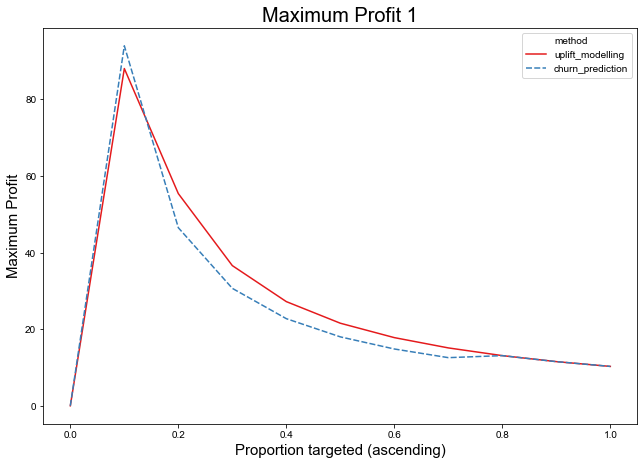

In [38]:
sns.lineplot(x='n', y='mp', hue='method', data=result_mp1, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('Maximum Profit 1',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

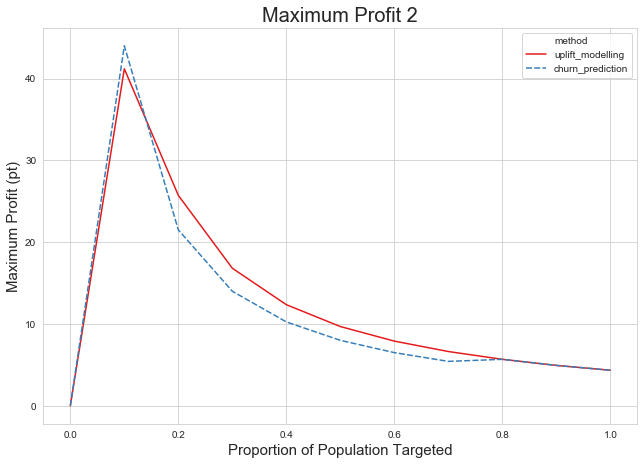

In [39]:
sns.lineplot(x='n', y='mp', hue='method', data=result_mp2, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('Maximum Profit 2',fontsize=20)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.ylabel('Maximum Profit (pt)',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

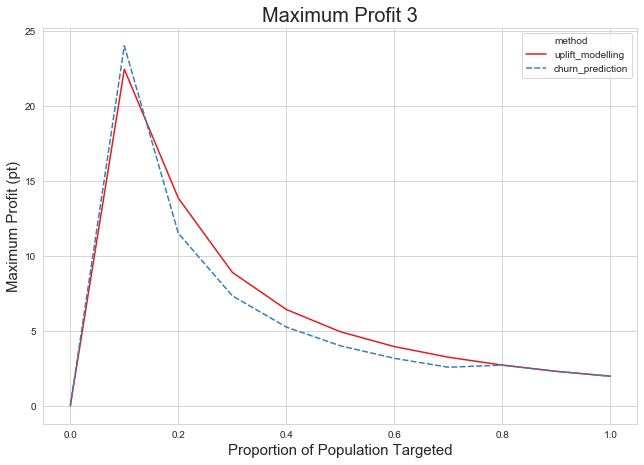

In [40]:
sns.lineplot(x='n', y='mp', hue='method', data=result_mp3, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('Maximum Profit 3',fontsize=20)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.ylabel('Maximum Profit (pt)',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

<h2>Treatment and Control

In [42]:
df_data_uplift_all

,index,target_class,Stay,promotion_last_5years,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
0,12330,0,0,0,0,0.913118,0.000169,0.000123,0.086590,1.996783
1,5062,0,0,0,0,0.978884,0.002144,0.000182,0.018790,1.976481
2,5137,0,0,0,0,0.984369,0.008724,0.000034,0.006873,1.972507
3,11277,0,0,0,0,0.978464,0.019511,0.000039,0.001986,1.922436
4,1966,0,0,0,0,0.985989,0.012275,0.000046,0.001690,1.922421
...,...,...,...,...,...,...,...,...,...,...
14994,3874,1,1,0,1,0.005572,0.975105,0.019314,0.000009,-1.987709
14995,9093,1,1,0,1,0.005638,0.984435,0.009924,0.000004,-1.987885
14996,6376,1,1,0,1,0.005638,0.984435,0.009924,0.000004,-1.987885
14997,9587,1,1,0,1,0.005638,0.984435,0.009924,0.000004,-1.987885


In [44]:
#prepare 3 dataframe for CPMPU
CPMPU1 = pd.DataFrame({"n":[], 
                      "QINI":[], 
                      "TR":[],  
                      "mpu":[]})
CPMPU2, CPMPU3, CUMPU1, CUMPU2, CUMPU3=CPMPU1.copy(), CPMPU1.copy(), CPMPU1.copy(), CPMPU1.copy(), CPMPU1.copy()
CP_list1, CP_list2, CP_list3, CU_list1, CU_list2, CU_list3=[], [], [], [], [], []
#prepare QU & QC dataframe
QU = pd.DataFrame({"n":[],  
                    "uplift":[]})
QC = QU.copy()
k = round(len(df_data_churn_all)/10)
QU_list, QC_list = [],[]
p4_1=(b1-c)
p4_2=(b2-c)
p4_3=(b3-c)


for i in range(10):
    m=(i+1)*k 
        
    #Qini Churn Variables
    RC_churn=sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all.promotion_last_5years[0:m]==0))
    RT_churn=sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all.promotion_last_5years[0:m]==1))
    NC_churn=sum(df_data_churn_all.promotion_last_5years[0:m]==0)
    NT_churn=sum(df_data_churn_all.promotion_last_5years[0:m]==1)
    QINI_c = RT_churn-((RC_churn*NT_churn)/NC_churn)
    QINI_churn = QINI_c
    if i>=1:
        QINI_churn = QINI_c/(i+1)
    QC_list.append(pd.Series([((i+1)/10), QINI_churn], index=QC.columns))
    
    #Qini Uplift Variables
    RC=sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all.promotion_last_5years[0:m]==0))
    RT=sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all.promotion_last_5years[0:m]==1))
    NC=sum(df_data_uplift_all.promotion_last_5years[0:m]==0)
    NT=sum(df_data_uplift_all.promotion_last_5years[0:m]==1)
    QINI_u = RT-((RC*NT)/NC)
    QINI_uplift = QINI_u
    if i>=1:
        QINI_uplift = QINI_u/(i+1)
    QU_list.append(pd.Series([((i+1)/10), QINI_uplift], index=QU.columns))
    
    
    #TR
    TR_churn=sum(df_data_churn_all.target_class[0:m] == 3)
    TR_uplift=sum(df_data_uplift_all.target_class[0:m] == 3)
    CPMPU1
    #Churn Prediction mpu 
    #Qini & TR for churn prediction
    u_profit1=(QINI_c*p4_1)
    tr_profit1=(TR_churn*i1)
    u_profit2=(QINI_c*p4_2)
    tr_profit2=(TR_churn*i2)
    u_profit3=(QINI_c*p4_3)
    tr_profit3=(TR_churn*i3)
    
    #churn Maximum Profit Uplift
    mpu1=(u_profit1 - tr_profit1)/m
    mpu2=(u_profit2 - tr_profit2)/m
    mpu3=(u_profit3 - tr_profit3)/m
    
    #Qini & TR for uplift prediction
    u_u_profit1=(QINI_u*p4_1)
    u_tr_profit1=(TR_uplift*i1)
    u_u_profit2=(QINI_u*p4_2)
    u_tr_profit2=(TR_uplift*i2)
    u_u_profit3=(QINI_u*p4_3)
    u_tr_profit3=(TR_uplift*i3)
    
    #Churn Uplift Maximum Profit Uplift
    u_mpu1=(u_u_profit1 - u_tr_profit1)/m
    u_mpu2=(u_u_profit2 - u_tr_profit2)/m
    u_mpu3=(u_u_profit3 - u_tr_profit3)/m
    
    CP_list1.append(pd.Series([((i+1)/10), QINI_c, TR_churn, mpu1], index=CPMPU1.columns))
    CP_list2.append(pd.Series([((i+1)/10), QINI_c, TR_churn, mpu2], index=CPMPU2.columns))    
    CP_list3.append(pd.Series([((i+1)/10), QINI_c, TR_churn, mpu3], index=CPMPU3.columns))    
        
    CU_list1.append(pd.Series([((i+1)/10), QINI_u, TR_uplift, u_mpu1], index=CUMPU1.columns))
    CU_list2.append(pd.Series([((i+1)/10), QINI_u, TR_uplift, u_mpu2], index=CUMPU2.columns))    
    CU_list3.append(pd.Series([((i+1)/10), QINI_u, TR_uplift, u_mpu3], index=CUMPU3.columns)) 
    
    
# append list into dataframe    
QU = QU.append(QU_list , ignore_index=True)
QC = QC.append(QC_list , ignore_index=True)
# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'uplift':0}, index =[0])
QU = pd.concat([q0, QU]).reset_index(drop = True)
QC = pd.concat([q0, QC]).reset_index(drop = True)

# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'mpu':0}, index =[0])
# append list into dataframe    
CPMPU1 = CPMPU1.append(CP_list1 , ignore_index=True)
CPMPU2 = CPMPU2.append(CP_list2 , ignore_index=True)
CPMPU3 = CPMPU3.append(CP_list3 , ignore_index=True)

CUMPU1 = CUMPU1.append(CU_list1 , ignore_index=True)
CUMPU2 = CUMPU2.append(CU_list2 , ignore_index=True)
CUMPU3 = CUMPU3.append(CU_list3 , ignore_index=True)

# add q0 into dataframe
CPMPU1 = pd.concat([q0, CPMPU1]).reset_index(drop = True)
CPMPU2 = pd.concat([q0, CPMPU2]).reset_index(drop = True)
CPMPU3 = pd.concat([q0, CPMPU3]).reset_index(drop = True)

CUMPU1 = pd.concat([q0, CUMPU1]).reset_index(drop = True)
CUMPU2 = pd.concat([q0, CUMPU2]).reset_index(drop = True)
CUMPU3 = pd.concat([q0, CUMPU3]).reset_index(drop = True)

In [45]:
CUMPU1

,n,mpu,QINI,TR
0,0.0,0.000000,NaN,NaN
1,0.1,0.742644,5.899329,6.0
2,0.2,0.365588,5.812877,6.0
3,0.3,0.529077,12.617312,13.0
4,0.4,0.487948,15.516015,16.0
5,0.5,0.462139,18.372062,19.0
6,0.6,0.362894,17.367077,19.0
7,0.7,0.276387,15.538012,19.0
8,0.8,0.019479,2.129363,19.0
9,0.9,-0.469971,-30.927699,19.0


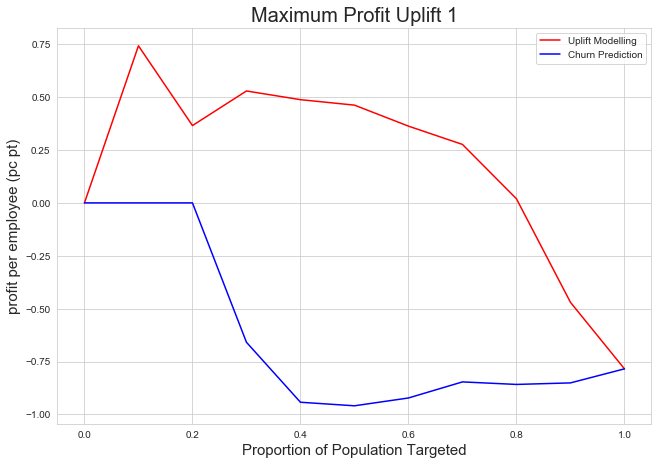

In [46]:
sns.lineplot(x=CUMPU1.n, y=CUMPU1.mpu, label='Uplift Modelling', color='red')
sns.lineplot(x=CPMPU1.n, y=CPMPU1.mpu, label='Churn Prediction', color='blue')

sns.set_style("whitegrid")
plt.title('Maximum Profit Uplift 1',fontsize=20)
plt.ylabel('profit per employee (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

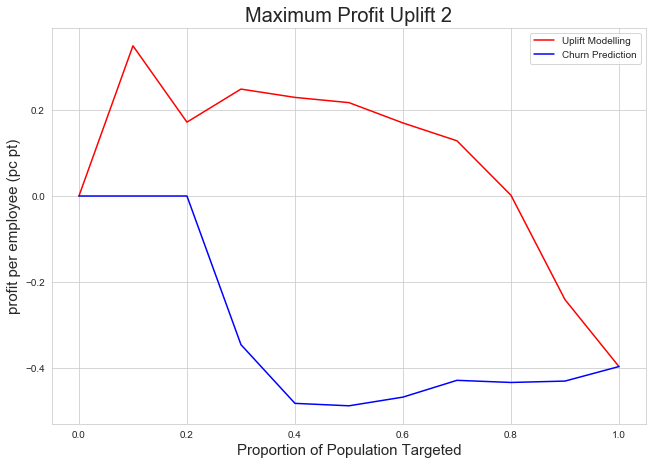

In [47]:
sns.lineplot(x=CUMPU2.n, y=CUMPU2.mpu, label='Uplift Modelling', color='red')
sns.lineplot(x=CPMPU2.n, y=CPMPU2.mpu, label='Churn Prediction', color='blue')

sns.set_style("whitegrid")
plt.title('Maximum Profit Uplift 2',fontsize=20)
plt.ylabel('profit per employee (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

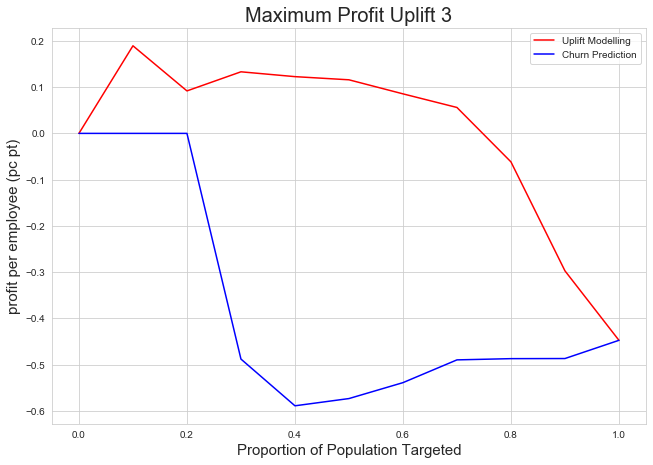

In [48]:
sns.lineplot(x=CUMPU3.n, y=CUMPU3.mpu, label='Uplift Modelling', color='red')
sns.lineplot(x=CPMPU3.n, y=CPMPU3.mpu, label='Churn Prediction', color='blue')

sns.set_style("whitegrid")
plt.title('Maximum Profit Uplift 3',fontsize=20)
plt.ylabel('profit per employee (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

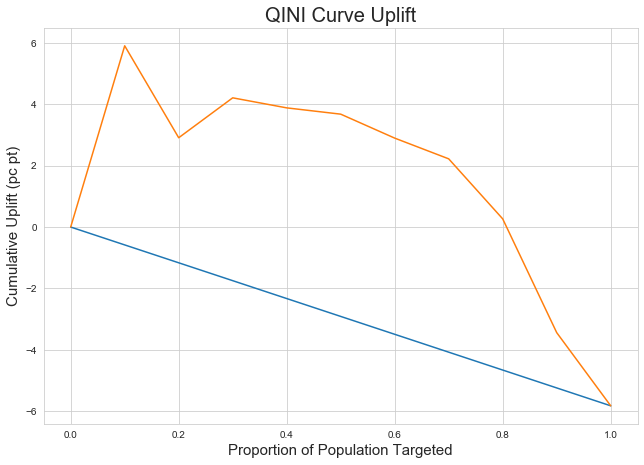

In [49]:
random = np.linspace(QU['uplift'][0],QU['uplift'][10],11)
sns.lineplot(x=QU.n, y=random)
sns.lineplot(x=QU.n, y=QU.uplift)

sns.set_style("whitegrid")
plt.title('QINI Curve Uplift',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

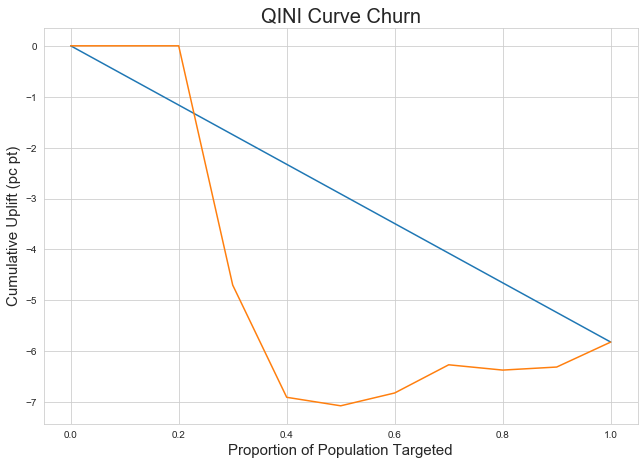

In [50]:
random = np.linspace(QC['uplift'][0],QC['uplift'][10],11)
sns.lineplot(x=QC.n, y=random)
sns.lineplot(x=QC.n, y=QC.uplift)
sns.set_style("whitegrid")
plt.title('QINI Curve Churn',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

<h2>Pylift

In [ ]:
df_data_pylift = df_model.copy()
df_data_pylift.drop(['target_class'], axis=1)
df_data_pylift

pylift modelling

In [ ]:
up = TransformedOutcome(df_model, col_treatment=treat, col_outcome='Stay')

In [ ]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

In [ ]:
up.fit(**up.rand_search_.best_params_)

In [ ]:
up.plot(plot_type='cuplift')

In [ ]:
up.test_results_.q1_cgains

In [ ]:
up.plot(plot_type='qini')

In [ ]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

In [ ]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>Causal Lift

In [ ]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [ ]:
cum_lift = calc_cumulative_gains(df_data_churn, 'Stay', 'p_stay', 'stay_score')
cum_lift

In [ ]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_lift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_lift, label="Average Case (for current model)")

In [ ]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_lift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_lift, label="Normalised Respond Rate Avg")

In [ ]:
cum_uplift = calc_cumulative_gains(df_data_uplift, 'target_class', 'p_target', 'uplift_score')
cum_uplift

In [ ]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_uplift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_uplift, label="Average Case (for current model)")

In [ ]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_uplift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_uplift, label="Normalised Respond Rate Avg")

In [ ]:
#create feature set and labels
df_model_causal = df_model.drop(['target_class','p_stay','p_target'],axis=1)
df_model_causal.rename(columns={treat:'Treatment','Stay':'Outcome'}, inplace=True)
df_model_causal

In [ ]:
#splitting train and test groups
train_df, test_df = train_test_split(df_model_causal, test_size=0.2, random_state=42, stratify=df_model_causal['Treatment'])

In [ ]:
""" Step 0. Import CausalLift
"""

from causallift import CausalLift

""" Step 1. Feed datasets and optionally compute estimated propensity scores
using logistic regression if set enable_ipw = True.
"""


cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

""" Step 2. Train 2 classification models (XGBoost) for treated and untreated
samples independently and compute estimated CATE (Conditional Average Treatment
Effect), ITE (Individual Treatment Effect), or uplift score.
"""

train_df, test_df = cl.estimate_cate_by_2_models()

""" Step 3. Estimate how much conversion rate will increase by selecting treatment
(campaign) targets as recommended by the uplift modeling.
"""

estimated_effect_df = cl.estimate_recommendation_impact()

In [ ]:
estimated_effect_df